In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
# 2. Load the Datasets
# Load the Kaggle dataset
kaggle_df = pd.read_csv('Data/Data.csv')

# Load the ISOT datasets
true_df = pd.read_csv('Data/True.csv')
fake_df = pd.read_csv('Data/Fake.csv')

# For ISOT, assign labels
true_df['label'] = 1
fake_df['label'] = 0

In [3]:
# 3. Combine the Datasets
# Combine the two ISOT datasets
isot_df = pd.concat([true_df, fake_df], ignore_index=True)

print("Kaggle dataset shape:", kaggle_df.shape)
print("ISOT dataset shape:", isot_df.shape)

# Combine Kaggle and ISOT data into one DataFrame
df = pd.concat([kaggle_df, isot_df], ignore_index=True)

# Shuffle the combined dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset shape:", df.shape)

Kaggle dataset shape: (20800, 5)
ISOT dataset shape: (44898, 5)
Combined dataset shape: (65698, 7)


In [4]:
# 4. Handle Missing Values
# Drop rows missing 'text'
df = df.dropna(subset=['text'])

# Fill missing 'title' values with a placeholder
df['title'] = df['title'].fillna("No Title Provided")

if 'author' in df.columns:
    df['author'] = df['author'].fillna("Unknown")

In [5]:
# 5. Create the 'content' Column
# Combine 'title' and 'text' into a single text field
if 'content' not in df.columns:
    df['content'] = df['title'] + " " + df['text']

In [6]:
# 6. Split into Training and Testing Sets
X = df['content']
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 7. Preprocess Text for the LSTM

def tokenize(text):
    # Convert text to lowercase to ensure case insensitivity.
    text = text.lower()
    # Use regex to split the text into tokens based on word boundaries.
    # This will match words consisting of alphanumeric characters.
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build a vocabulary from the training texts.
all_tokens = []
# Loop over each training text and accumulate all tokens.
for text in X_train:
    all_tokens.extend(tokenize(text))

# Count the frequency of each token in the training set.
freq = Counter(all_tokens)
# Build a vocabulary mapping where each word is assigned a unique integer.
# Reserve index 0 for padding and index 1 for tokens that are not found (unknown).
vocab = {word: i+2 for i, (word, count) in enumerate(freq.items())}
# Compute the total vocabulary size including the reserved indices.
vocab_size = len(vocab) + 2

def text_to_sequence(text, vocab):
    # Tokenize the text using our defined function.
    tokens = tokenize(text)
    # Convert each token into its corresponding integer based on the vocabulary.
    # If the token is not found in the vocabulary, assign it the unknown token index (1).
    return [vocab.get(token, 1) for token in tokens]

# Convert all texts in both training and testing sets into sequences of integers.
X_train_seq = [text_to_sequence(text, vocab) for text in X_train]
X_test_seq = [text_to_sequence(text, vocab) for text in X_test]

# Define the maximum sequence length to standardize input sizes.
max_len = 500

def pad_sequence(seq, max_len):
    # If the sequence is shorter than max_len, pad it with zeros (padding index).
    if len(seq) < max_len:
        return seq + [0]*(max_len - len(seq))
    # If the sequence is longer, truncate it to max_len.
    else:
        return seq[:max_len]

# Apply padding or truncation to every sequence in the training and test sets.
X_train_pad = [pad_sequence(seq, max_len) for seq in X_train_seq]
X_test_pad = [pad_sequence(seq, max_len) for seq in X_test_seq]

# Convert the padded sequences into torch tensors with the appropriate data type.
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)

# Convert the labels from the pandas Series into torch tensors for model training.
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [8]:
# 8. Create a PyTorch Dataset and DataLoader
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

batch_size = 64
train_dataset = NewsDataset(X_train_tensor, y_train_tensor)
test_dataset = NewsDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# 9. Define the LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        # Embedding layer converts word indices into dense vectors.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # LSTM processes sequences of embeddings; batch_first=True means input shape is (batch, seq, feature).
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer maps the hidden state to output dimension (number of classes).
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Convert indices in x to embeddings.
        x = self.embedding(x)
        # Pass the embeddings through LSTM layer.
        lstm_out, _ = self.lstm(x)
        # Select the output of the last time step for each sequence.
        last_hidden = lstm_out[:, -1, :]
        # Produce final logits via the fully connected layer.
        return self.fc(last_hidden)

# Hyperparameters: embedding size, hidden dimension, and output classes.
embedding_dim = 100       # Size of each word vector.
hidden_dim = 128          # Number of hidden units in LSTM.
output_dim = 2            # Number of classes (e.g., fake vs. true news).

# Instantiate the LSTM classifier model.
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)


In [10]:
# The following code trains the LSTM model on a GPU if available.
# It sets up device specification, loss function, optimizer, and iterates through training epochs.

# Determine whether to use a specific GPU (cuda:2) or CPU if a GPU isn't available.
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the loss criteria and the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

train_acc_history = []
val_acc_history = []

# Loop over epochs to train the model.
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Process each batch from the training data.
    for texts, labels in train_loader:
        # Move both inputs and labels to the designated device (GPU or CPU).
        texts = texts.to(device)
        labels = labels.to(device)
        
        # Clear the gradients from the previous iteration.
        optimizer.zero_grad()
        
        # Forward pass: compute the model outputs for the given texts.
        outputs = model(texts)
        
        # Compute the cross-entropy loss between outputs and true labels.
        loss = criterion(outputs, labels)
        
        # Backward pass: calculate gradients of the loss with respect to model parameters.
        loss.backward()
        
        # Update model parameters based on computed gradients.
        optimizer.step()
        
        # Multiply the batch loss by the batch size and add to the running loss.
        running_loss += loss.item() * texts.size(0)
        
        # Determine the predicted classes by selecting the index with the highest logit.
        _, predicted = torch.max(outputs, 1)
        
        # Keep track of the total number of labels processed.
        total += labels.size(0)
        
        # Count the number of correct predictions.
        correct += (predicted == labels).sum().item()
    
    # Compute average loss and accuracy for the current epoch.
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_acc_history.append(epoch_acc)

    # Use test_loader as a validation proxy since there is no separate validation split.
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct / val_total if val_total else 0.0
    val_acc_history.append(val_acc)
    model.train()
    
    # Output the epoch's performance metrics.
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f} - Val Accuracy: {val_acc:.4f}")



Epoch 1/5 - Loss: 0.6560 - Accuracy: 0.6130 - Val Accuracy: 0.6899
Epoch 2/5 - Loss: 0.6201 - Accuracy: 0.6502 - Val Accuracy: 0.8219
Epoch 3/5 - Loss: 0.2263 - Accuracy: 0.9105 - Val Accuracy: 0.9469
Epoch 4/5 - Loss: 0.0959 - Accuracy: 0.9656 - Val Accuracy: 0.9622
Epoch 5/5 - Loss: 0.0485 - Accuracy: 0.9848 - Val Accuracy: 0.9670


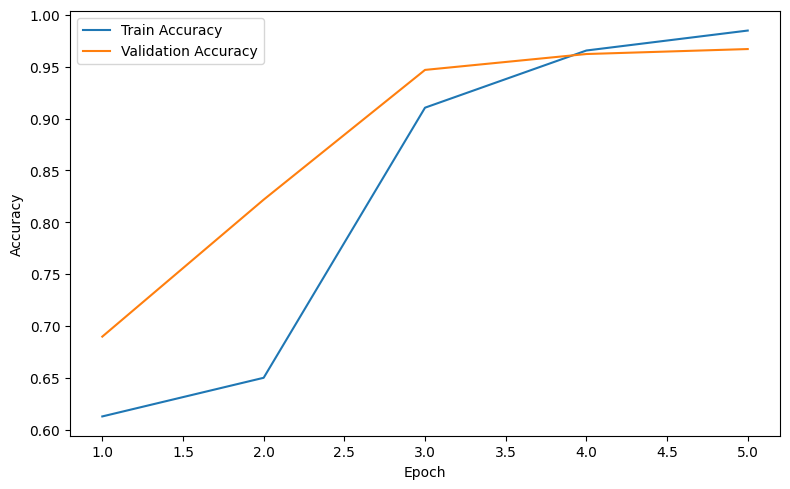

In [11]:
# Plot training (and validation) accuracy across epochs
epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
if len(val_acc_history) == len(train_acc_history) and len(val_acc_history) > 0:
    plt.plot(epochs, val_acc_history, label='Validation Accuracy')
else:
    # No validation loader/split available; plotting training accuracy only.
    pass

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('lstm_training_curves.png', dpi=300)



In [12]:
# Evaluation Cell for LSTM.ipynb

# Import evaluation metrics for assessing classification performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize empty lists to store the predicted outputs and the true labels for the test set
all_preds = []
all_labels = []

# Set the model to evaluation mode so that layers like dropout behave correctly
model.eval()  

# Disable gradient computation since we are only doing inference
with torch.no_grad():
    # Iterate over all batches from the test loader
    for texts, labels in test_loader:
        # Move the texts and labels to the appropriate device (GPU or CPU)
        texts = texts.to(device)
        labels = labels.to(device)

        # Compute the outputs from the model for the current batch
        outputs = model(texts)
        
        # Determine the predicted class by selecting the one with the highest score
        _, predicted = torch.max(outputs, 1)

        # Convert predictions and labels to numpy arrays and store them for evaluation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')


print("LSTM Test Accuracy:", acc)
print("LSTM Test Precision:", prec)
print("LSTM Test Recall:", rec)
print("LSTM Test F1-Score:", f1)

LSTM Test Accuracy: 0.9670271093512032
LSTM Test Precision: 0.9671452018384409
LSTM Test Recall: 0.9670271093512032
LSTM Test F1-Score: 0.9670143577837089
